# Function Definitions

## RBFNN coreset definition

In [ ]:
import numpy as np
from scipy.optimize import approx_fprime
import scipy as sp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.io import loadmat
import time
import numpy.linalg as la
import copy
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt


np.seterr(all='raise')


class MVEEApprox(object):
    Epsilon = 1e-6

    def __init__(self, P, cost_func, maxIter=10, bound=1):
        self.cost_func = cost_func
        self.P = P
        self.bound = bound
        self.maxIter = maxIter
        self.c = np.zeros((P.shape[1], ))
        self.G = max(np.sqrt(P.shape[0]), np.max(np.sum(np.abs(P)**2,axis=-1)**(0.5))) * np.eye(P.shape[1], P.shape[1])
        self.oldG = copy.deepcopy(self.G)


    def separation_oracle(self, x):
        # grad = approx_fprime(x, self.cost_func, self.Epsilon)
        grad = self.P.T.dot(np.sign(self.P.dot(x)))
        return grad / np.linalg.norm(grad, np.inf)

    def get_axis_points(self):
        if np.any(np.isnan(self.G)):
            raise ValueError('WHATT!!!!')
        U, s, vh = np.linalg.svd(self.G, full_matrices=True)
        # volume = np.prod(np.sqrt(s))
        d = s.shape[0]
        A = np.dot(np.diag(np.sqrt(s) / np.sqrt(d + 1)), U.T)
        points = np.vstack((A, -A))
        # points = np.tile(, vh.T)), d, axis=0)
        # temp = np.repeat(np.vstack((self.c[:, np.newaxis].T, -self.c[:, np.newaxis].T)), d, axis=0)
        temp = np.tile(self.c[:, np.newaxis].T, (2*d, 1))
        return points + temp

    def check_if_inside(self, P):
        #vals = np.apply_along_axis(self.cost_func, 1, P)
        vals = np.linalg.norm(P.dot(self.P.T), ord=1, axis=1)
        i = np.argmax(vals, axis=0)
        if vals[i] <= 1:
            return np.inf, vals[i]

        print('Maximal Value: {:.4f}'.format(vals[i]))

        return i, vals[i]

    def basic_ellipsoid_method(self):
        d = np.ma.size(self.P, axis=1)

        self.oldG = copy.deepcopy(self.G)
        while self.cost_func(self.c) > 1 :
            H = self.separation_oracle(self.c)
            b = np.dot(self.G, H) / np.sqrt(np.abs(np.dot(H, np.dot(self.G, H))))
            self.c = self.c - 1.0 / (d + 1.0) * b
            self.G = d ** 2.0 / (d ** 2.0 - 1.0) * (self.G - (2.0 / (d + 1.0)) * np.dot(b[:, np.newaxis], b[:, np.newaxis].T))

        if not self.isPD(self.G):
            print('Corrected back to PSD at Basic ellipsoid method')
            self.G = self.nearestPD(self.G)


    def shallow_cut_update(self, point):
        d = np.ma.size(self.G, 0)
        rho = 1.0 / (d + 1.0) ** 2.0
        sigma = d ** 3.0 * (d + 2.0) / ((d + 1) ** 3.0 * (d - 1.0))
        zeta = 1.0 + 1.0 / (2.0 * d ** 2.0 * (d + 1.0) ** 2.0)
        tau = 2.0 / ((d + 1.0) * d)

        b = np.dot(self.G, point) / np.sqrt(np.abs(np.dot(point, np.dot(self.G, point))))
        self.oldG = copy.deepcopy(self.G)
        self.G = zeta * sigma * (self.G - tau * np.dot(b[:, np.newaxis], b[:, np.newaxis].T))
        self.c = self.c - rho * b

        if not self.isPD(self.G):
            print('Corrected back to PSD at Shallow cut update')
            self.G = self.nearestPD(self.G)

    def compute_approximated_MVEE(self):
        stop = False
        iter = 0
        while not stop:
            s = time.time()
            self.basic_ellipsoid_method()
            print(time.time() - s)

            s = time.time()
            axis_points = self.get_axis_points()
            print(time.time() - s)
            i, val = self.check_if_inside(axis_points)
            if np.isinf(i):
                stop = True
            else:
                sep_grad = self.separation_oracle(axis_points[i, :])
                self.shallow_cut_update(sep_grad)

            if iter > self.maxIter:
                self.G = self.G / val
                iter = 0
                print('HMM')
                continue
            iter += 1

        E = np.linalg.cholesky(self.G)
        return E, self.c

    @staticmethod
    def nearestPD(A):
        """Find the nearest positive-definite matrix to input

        A Python/Numpy port of John D'Errico's nearestSPD MATLAB code [1], which
        credits [2].

        [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

        [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
        matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
        """

        B = (A + A.T) / 2
        _, s, V = la.svd(B)

        H = np.dot(V.T, np.dot(np.diag(s), V))

        A2 = (B + H) / 2

        A3 = (A2 + A2.T) / 2

        if MVEEApprox.isPD(A3):
            return A3

        spacing = np.spacing(la.norm(A))
        # The above is different from [1]. It appears that MATLAB's chol Cholesky
        # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
        # Numpy's will not. So where [1] uses eps(mineig) (where eps is Matlab
        # for np.spacing), we use the above definition. CAVEAT: our spacing
        # will be much larger than [1]'s eps(mineig), since mineig is usually on
        # the order of 1e-16, and eps(1e-16) is on the order of 1e-34, whereas
        # spacing will, for Gaussian random matrixes of small dimension, be on
        # othe order of 1e-16. In practice, both ways converge, as the unit test
        # below suggests.
        I = np.eye(A.shape[0])
        k = 1
        while not MVEEApprox.isPD(A3):
            mineig = np.min(np.real(la.eigvals(A3)))
            A3 += I * (-mineig * k ** 2 + spacing)
            k += 1

        return A3

    @staticmethod
    def isPD(B):
        """Returns true when input is positive-definite, via Cholesky"""
        try:
            _ = la.cholesky(B)
            return True
        except la.LinAlgError:
            return False

    @staticmethod
    def plotEllipsoid(center, radii, rotation, ax=None, plotAxes=True, cageColor='r', cageAlpha=1):
        """Plot an ellipsoid"""
        make_ax = (ax is None)
        if make_ax:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

        u = np.linspace(0.0, 2.0 * np.pi, 100)
        v = np.linspace(0.0, np.pi, 100)

        # cartesian coordinates that correspond to the spherical angles:
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        # rotate accordingly
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i, j], y[i, j], z[i, j]] = np.dot(np.array([x[i, j], y[i, j], z[i, j]]), rotation) + center.flatten()

        if plotAxes:
            # make some purdy axes
            axes = np.array([[radii[0], 0.0, 0.0],
                             [0.0, radii[1], 0.0],
                             [0.0, 0.0, radii[2]]])
            # rotate accordingly
            for i in range(len(axes)):
                axes[i] = np.dot(axes[i], rotation)

            print('Axis are: ', axes)
            # print(axes + center.flatten())

            # plot axes
            print('Whole points are: ')
            for p in axes:
                X3 = np.linspace(-p[0], p[0], 2) + center[0]
                Y3 = np.linspace(-p[1], p[1], 2) + center[1]
                Z3 = np.linspace(-p[2], p[2], 2) + center[2]
                ax.plot3D(X3, Y3, Z3, color='m')
                PP = np.vstack((X3, Y3, Z3)).T
                print(PP)

        # plot ellipsoid
        ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)
        plt.show()

    def plotBodyAndEllips(self, B, E):
        N = 10000
        U, D, V = np.linalg.svd(E, full_matrices=True)
        a = D[0]
        b = D[1]
        theta = np.expand_dims(np.arange(start=0, step=1.0 / N, stop=2.0 * np.pi + 1.0 / N), 1).T

        state = np.vstack((a * np.cos(theta), b * np.sin(theta)))
        X = np.dot(U, state) + self.c[:, np.newaxis]

        ax = plt.subplot(111)
        plt.plot(X[0, :], X[1, :], color='black', linewidth=5)

        vals = np.apply_along_axis(lambda x: np.linalg.norm(x.flatten() - self.c.flatten()), 0, X)
        i = np.argmax(vals)

        print(X[:, i])

        plt.scatter(self.c[0], self.c[1], marker='+', color='green')
        plt.grid(True)

        # hull = ConvexHull(B)
        # for simplex in hull.simplices:
        #     plt.plot(B[simplex, 0], B[simplex, 1], 'k-')

        # plt.scatter(B[:, 0], B[:, 1], marker='D', color='orange')

        # plt.scatter(self.c[0], self.c[1], marker='^', color='green')
        # plt.scatter(X[0, i], X[1, i], marker='*', color='black')
        plt.scatter(B[:, 0], B[:, 1], marker='*', color='green')
        plt.show()

    @staticmethod
    def main():
        P = np.random.rand(10000, 400)
        cost_func = lambda x: np.linalg.norm(np.dot(P, x), ord=1)
        tol = 1/100
        start_time = time.time()

        mvee = MVEEApprox(P, cost_func, maxIter=10)
        E, C = mvee.compute_approximated_MVEE()

        print('Ellip took {:.4f}'.format(time.time() - start_time))
        if P.shape[1] <= 3:
            N = 1000
            X = np.random.randn(N, P.shape[1])
            vals = np.apply_along_axis(cost_func, 1, X)
            X = np.multiply(X, 1.0 / vals[:, np.newaxis])
            if P.shape[1] == 2:
                mvee.plotBodyAndEllips(X, E)
            else:
                fig = plt.figure()
                ax = plt.axes(projection='3d')

                # from scipy.spatial import ConvexHull
                # hull = ConvexHull(X)

                # Plot defining corner points
                # ax.plot(X.T[0], X.T[1], X.T[2], "ko")
                # for s in hull.simplices:
                #     s = np.append(s, s[0])  # Here we cycle back to the first coordinate
                #     ax.plot(X[s, 0], X[s, 1], X[s, 2], "b-")
                ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], color='black', marker='o')
                U, D, V = la.svd(E, full_matrices=True)
                mvee.plotEllipsoid(C, D, U.T, ax=ax)

R = 10

def obtainSensitivity(X, w, approxMVEE=False):
    if not approxMVEE:
        raise Exception
    else:
        cost_func = lambda x: np.linalg.norm(np.dot(X, x), ord=1)
        mvee = MVEEApprox(X, cost_func, 3)
        ellipsoid, center = mvee.compute_approximated_MVEE()
        U = X.dot(ellipsoid)
        return np.linalg.norm(U, ord=1, axis=1)


def generateCoreset(X, y, sensitivity, sample_size, weights=None, SEED=1):
    if weights is None:
        weights = np.ones((X.shape[0], 1)).flatten()

    # Compute the sum of sensitivities.
    t = np.sum(sensitivity)

    # The probability of a point prob(p_i) = s(p_i) / t
    probability = sensitivity.flatten() / t

    startTime = time.time()

    # initialize new seed
    np.random.seed()

    # Multinomial Distribution
    hist = np.random.choice(np.arange(probability.shape[0]), size=sample_size, replace=False, p=probability.flatten())
    indxs, counts = np.unique(hist, return_counts=True)
    S = X[indxs]
    labels = y[indxs]

    # Compute the weights of each point: w_i = (number of times i is sampled) / (sampleSize * prob(p_i))
    weights = np.asarray(np.multiply(weights[indxs], counts), dtype=float).flatten()

    weights = np.multiply(weights, 1.0 / (probability[indxs] * sample_size))
    timeTaken = time.time() - startTime

    return indxs, S, labels, weights, timeTaken

## GAN models

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))

class Generator(nn.Module):
    def __init__(self, in_channels):
        super(Generator, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 28 -> 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Bottleneck
        self.res_blocks = nn.Sequential(
            ResBlock(256),
            ResBlock(256),
            ResBlock(256)
        )

        # Decoder
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 7 -> 14
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14 -> 28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, kernel_size=3, padding=1), # Change this in the PCA case
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        r = self.res_blocks(e3)

        d2 = self.dec2(r)
        d1 = self.dec1(d2)
        out = self.final(d1)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)

class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()

    def forward(self, preds, labels, weights):
        # Ensure the predictions and labels are the correct shapes (same as batch size)
        # Apply the BCE loss with reduction='none' to get the loss for each sample
        if weights is None:
            weights = 1
        bce_loss = nn.BCELoss(reduction='none')
        loss_per_sample = bce_loss(preds, labels)

        # Multiply the per-sample loss by the corresponding weight
        weighted_loss = loss_per_sample * weights

        # Return the mean (or sum) of the weighted loss
        return weighted_loss.mean()

class WeightedL1Loss(nn.Module):
    def __init__(self):
        super(WeightedL1Loss, self).__init__()

    def forward(self, preds, labels, weights):
        # Apply the L1 loss with reduction='none' to get the loss for each sample
        if weights is None:
            weights_broadcasted = 1
        else:
          weights_broadcasted = weights[:, None, None, None]
        l1_loss = nn.L1Loss(reduction='none')
        loss_per_sample = l1_loss(preds, labels)

        # Multiply the per-sample loss by the corresponding weight
        weighted_loss = loss_per_sample * weights_broadcasted

        # Return the mean (or sum) of the weighted loss
        return weighted_loss.mean()  # You can use .sum() if you prefer summing the losses

# Dataset construction

In [ ]:
# %%capture
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_moons

# # ----- 1. create a tiny data set --------------------------------------------
# X_raw, y = make_moons(n_samples=1000, noise=0.08, random_state=0)

# # ----- 2. scale to the unit ball (‖x‖₂ ≤ 1) ---------------------------------
# R = np.max(np.linalg.norm(X_raw, axis=1))
# X_scaled = X_raw / R            #  now every point satisfies ‖x‖₂ ≤ 1

# # ----- 3. lifting step  q_p = [‖x‖² , -2xᵀ , 1] ------------------------------
# phi = np.hstack([
#     np.sum(X_scaled**2, axis=1, keepdims=True),   # ‖x‖₂²
#     -2 * X_scaled,                                # -2 xᵀ
#     np.ones((X_scaled.shape[0], 1))               # 1
# ])

# # ----- 4. sensitivities & coreset -------------------------------------------
# sens = obtainSensitivity(phi, w=None, approxMVEE=True)
# m     = 50                                        # coreset size
# idx, _, _, wts, _ = generateCoreset(phi, y, sens, m)

# # ----- 5. visualise ----------------------------------------------------------
# plt.figure(figsize=(6, 5))
# plt.scatter(X_scaled[:, 0], X_scaled[:, 1],
#             c='lightgrey', s=8, label='original data')
# plt.scatter(X_scaled[idx, 0], X_scaled[idx, 1],
#             c='crimson',   s=50*np.sqrt(wts), edgecolors='k',
#             label='coreset (m=100)')
# plt.legend(); plt.axis('equal'); plt.show()


In [ ]:
# %%capture
# import numpy as np
# from sklearn.decomposition import PCA
# from tensorflow.keras.datasets import mnist, cifar10
# import time, json, pickle                                 # std‑lib only

# # ---------------------------------------------------------------------------
# # 1.  Load MNIST (60 000 train images, 28×28) and flatten to 784‑d vectors
# # ---------------------------------------------------------------------------
# (X_train, y_train), _ = cifar10.load_data()
# X = X_train.reshape(len(X_train), -1).astype('float32') / 255.0   # shape (60000, 784)

# # ---------------------------------------------------------------------------
# # 2.  PCA → 500‑d  (author’s setting)
# # ---------------------------------------------------------------------------
# pca = PCA(n_components=500, svd_solver='randomized', random_state=0)
# X_pca = pca.fit_transform(X)                                       # shape (60000, 500)

# # ---------------------------------------------------------------------------
# # 3.  Lifting step  ϕ(x) = [‖x‖₂² ,  x_pca ]
# # ---------------------------------------------------------------------------
# sq_norm = np.sum(X_pca**2, axis=1, keepdims=True)
# Phi     = np.hstack([sq_norm, X_pca])                              # shape (60000, 501)

# # ---------------------------------------------------------------------------
# # 4.  Sensitivities via the approximate MVEE
# # ---------------------------------------------------------------------------
# t0   = time.time()
# sens = obtainSensitivity(Phi, w=None, approxMVEE=True)             # 1‑D array (60000,)
# print(f"MVEE + sensitivities: {time.time()-t0:.1f}s")

# # ---------------------------------------------------------------------------
# # 5.  Build a 10 % coreset  (m = 6 000 points)
# # ---------------------------------------------------------------------------
# m    = 6000
# idx, _, _, wts, _ = generateCoreset(Phi, y_train, sens, m)
# print(f"indices shape = {idx.shape},  weights shape = {wts.shape}")

# # -------------- optional: save the subset for later ------------------------
# with open("mnist_coreset_indices.pkl", "wb") as f:
#     pickle.dump({"idx": idx, "weights": wts}, f)

In [ ]:
%%capture
import torch
import torch.utils.data
import numpy as np
from sklearn.decomposition import PCA
import time, json, pickle                                 # std‑lib only

# ---------------------------------------------------------------------------
# 1. Load CIFAR-10 using PyTorch (60,000 train images, 32x32) and flatten to 3072-d vectors
# ---------------------------------------------------------------------------
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=60000, shuffle=False)

# Get all the data
X_train, y_train = next(iter(train_loader))

# Flatten each image (32x32x3 = 3072)
X = X_train.view(len(X_train), -1).numpy().astype('float32')

# ---------------------------------------------------------------------------
# 2. PCA → 500-d (author’s setting)
# ---------------------------------------------------------------------------
pca = PCA(n_components=500, svd_solver='randomized', random_state=0)
X_pca = pca.fit_transform(X)  # shape (60000, 500)

# ---------------------------------------------------------------------------
# 3. Lifting step ϕ(x) = [‖x‖₂² , x_pca ]
# ---------------------------------------------------------------------------
sq_norm = np.sum(X_pca**2, axis=1, keepdims=True)
Phi     = np.hstack([sq_norm, X_pca])  # shape (60000, 501)

# ---------------------------------------------------------------------------
# 4. Sensitivities via the approximate MVEE
# ---------------------------------------------------------------------------
# Assuming `obtainSensitivity` is defined somewhere
t0   = time.time()
sens = obtainSensitivity(Phi, w=None, approxMVEE=True)  # 1‑D array (60000,)
print(f"MVEE + sensitivities: {time.time()-t0:.1f}s")

# ---------------------------------------------------------------------------
# 5. Build a 10% coreset (m = 6,000 points)
# ---------------------------------------------------------------------------
m    = 6000
# Assuming `generateCoreset` is defined somewhere
idx, _, _, wts, _ = generateCoreset(Phi, y_train, sens, m)
print(f"indices shape = {idx.shape},  weights shape = {wts.shape}")

# -------------- optional: save the subset for later ------------------------
with open("cifar10_coreset_indices.pkl", "wb") as f:
    pickle.dump({"idx": idx, "weights": wts}, f)


# Image Classification

In [ ]:
# -----------------------------------------------------------
#  run_coreset_experiment_resnet18_tqdm.py
# -----------------------------------------------------------
import time, json, pickle, torch, torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18
from tqdm.auto import tqdm           # ★ NEW

# ---------- helpers ----------------------------------------------------------
def _build_resnet18(num_classes, pretrained=False):
    model = resnet18(weights="IMAGENET1K_V1" if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def _train_one_epoch(model, loader, optimizer, criterion, device, pbar):   # ★ added pbar
    model.train()
    running_loss = 0.0; correct = 0; total = 0
    for data in loader:
        if len(data) == 3:
            imgs, labels, sw = data; sw = sw.to(device)
        else:
            imgs, labels = data; sw = None

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss_vec = criterion(outputs, labels)
        loss = (loss_vec * sw).mean() if sw is not None else loss_vec.mean()
        loss.backward(); optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item(); total += labels.size(0)
        pbar.update()                                     # ★ advance bar
    return running_loss / total, 100. * correct / total


def _eval(model, loader, criterion, device, desc="Eval"):                   # ★ progress bar
    model.eval(); running_loss = 0.0; correct = 0; total = 0
    with torch.no_grad(), tqdm(total=len(loader), desc=desc, leave=False) as pbar:  # ★
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels).mean()
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item(); total += labels.size(0)
            pbar.update()                                 # ★
    return running_loss / total, 100. * correct / total

# ---------- main routine -----------------------------------------------------
def run_coreset_experiment(train_dataset,
                           test_dataset,
                           pickle_path,
                           num_classes,
                           epochs=10,
                           batch_size_full=128,
                           batch_size_core=64,
                           pretrained=False,
                           lr=0.003,
                           device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss(reduction="none")

    # ------------ FULL run ---------------------------------------------------
    loader_full = DataLoader(train_dataset, batch_size=batch_size_full,
                             shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256,
                             shuffle=False, num_workers=2, pin_memory=True)

    model_full = _build_resnet18(num_classes, pretrained).to(device)
    optim_full = torch.optim.Adam(model_full.parameters(), lr=lr)

    t0 = time.time()
    for ep in range(epochs):
        with tqdm(total=len(loader_full),
                  desc=f"Full  |Epoch {ep+1}/{epochs}", leave=False) as pbar:  # ★
            _train_one_epoch(model_full, loader_full, optim_full,
                             criterion, device, pbar)
    time_full = time.time() - t0
    loss_full, acc_full = _eval(model_full, test_loader,
                                criterion, device, desc="Full  |Test")      # ★

    # ------------ CORESET run -----------------------------------------------
    with open(pickle_path, "rb") as f:
        d = pickle.load(f)
    idx, wts = d["idx"], torch.tensor(d["weights"]).float()
    core_ds = Subset(train_dataset, idx)

    class _CoreWrapper(torch.utils.data.Dataset):
        def __init__(self, subset, weights):
            self.subset, self.weights = subset, weights
        def __len__(self): return len(self.subset)
        def __getitem__(self, i):
            img, label = self.subset[i]
            return img, label, self.weights[i]

    core_loader = DataLoader(_CoreWrapper(core_ds, wts),
                             batch_size=batch_size_core,
                             shuffle=False, num_workers=2, pin_memory=True)

    model_core = _build_resnet18(num_classes, pretrained).to(device)
    optim_core = torch.optim.Adam(model_core.parameters(), lr=lr)

    t0 = time.time()
    for ep in range(epochs):
        with tqdm(total=len(core_loader),
                  desc=f"Coreset|Epoch {ep+1}/{epochs}", leave=False) as pbar:  # ★
            _train_one_epoch(model_core, core_loader, optim_core,
                             criterion, device, pbar)
    time_core = time.time() - t0
    loss_core, acc_core = _eval(model_core, test_loader,
                                criterion, device, desc="Coreset|Test")     # ★

    res = {
        "full":    {"loss": loss_full,  "acc": acc_full,  "time": time_full},
        "coreset": {"loss": loss_core,  "acc": acc_core,  "time": time_core},
        "speedup": time_full / time_core
    }
    print(json.dumps(res, indent=2))
    return res

In [ ]:
from torchvision import transforms, datasets

# 1.  define transforms that match ResNet‑18 expectations (3×224×224)
tfm = transforms.Compose([
    transforms.Resize(224),
    # transforms.Grayscale(3),            # MNIST → 3‑channel
    transforms.ToTensor()
])

# mnist_train = datasets.MNIST(root="./data", train=True,
#                              transform=tfm, download=True)
# mnist_test  = datasets.MNIST(root="./data", train=False,
#                              transform=tfm, download=True)
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

run_coreset_experiment(train_dataset=cifar10_train,
                       test_dataset=cifar10_test,
                       pickle_path="cifar10_coreset_indices.pkl",
                       num_classes=10,
                       epochs=4)

Full  |Epoch 1/4:   0%|          | 0/391 [00:00<?, ?it/s]

Full  |Epoch 2/4:   0%|          | 0/391 [00:00<?, ?it/s]

Full  |Epoch 3/4:   0%|          | 0/391 [00:00<?, ?it/s]

Full  |Epoch 4/4:   0%|          | 0/391 [00:00<?, ?it/s]

Full  |Test:   0%|          | 0/40 [00:00<?, ?it/s]

Coreset|Epoch 1/4:   0%|          | 0/94 [00:00<?, ?it/s]

Coreset|Epoch 2/4:   0%|          | 0/94 [00:00<?, ?it/s]

Coreset|Epoch 3/4:   0%|          | 0/94 [00:00<?, ?it/s]

Coreset|Epoch 4/4:   0%|          | 0/94 [00:00<?, ?it/s]

Coreset|Test:   0%|          | 0/40 [00:00<?, ?it/s]

{
  "full": {
    "loss": 0.8261307372093201,
    "acc": 72.08,
    "time": 67.81590580940247
  },
  "coreset": {
    "loss": 6.146267108154297,
    "acc": 32.84,
    "time": 12.345938205718994
  },
  "speedup": 5.49297304744229
}


{'full': {'loss': 0.8261307372093201, 'acc': 72.08, 'time': 67.81590580940247},
 'coreset': {'loss': 6.146267108154297,
  'acc': 32.84,
  'time': 12.345938205718994},
 'speedup': 5.49297304744229}

# GANs

In [ ]:
from torch.utils.data import DataLoader, Subset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])

# Comment this out when not doing coresets
pickle_path="cifar10_coreset_indices.pkl"
with open(pickle_path, "rb") as f:
    d = pickle.load(f)
idx, wts = d["idx"], torch.tensor(d["weights"]).float()

class _CoreWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, weights):
        self.subset, self.weights = subset, weights
    def __len__(self): return len(self.subset)
    def __getitem__(self, i):
        img, label = self.subset[i]
        return img, label, self.weights[i]

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
core_ds = Subset(train_dataset, idx)
# _CoreWrapper(core_ds, wts) Pass this for the coreset
# train_dataset pass this for the full dataset
train_loader = DataLoader(_CoreWrapper(core_ds, wts), batch_size=128, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def add_noise(imgs, noise_factor=0.2):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

G = Generator(in_channels=3).to(device)
D = Discriminator(in_channels=3).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# adversarial_loss = nn.BCELoss()
# reconstruction_loss = nn.L1Loss()
weighted_adversarial_loss = WeightedBCELoss()
weighted_reconstruction_loss = WeightedL1Loss()

epochs = 10
for epoch in range(epochs):
    G.train()
    D.train()
    for batch_idx, (data) in enumerate(train_loader):
        if len(data) == 3:
            imgs, labels, sw = data; sw = sw.to(device)
        else:
            imgs, labels = data; sw = None
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()

        reconstructed = G(noisy_imgs)
        g_adv = weighted_adversarial_loss(D(reconstructed), valid, sw)
        g_recon = weighted_reconstruction_loss(reconstructed, imgs, sw)
        g_loss = g_adv + 10 * g_recon  # Balance adversarial and reconstruction

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = weighted_adversarial_loss(D(imgs), valid, sw)
        fake_loss = weighted_adversarial_loss(D(reconstructed.detach()), fake, sw)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}")

G.eval()

total_recon_loss = 0
count = 0

all_originals = []
all_noisy = []
all_reconstructed = []

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        reconstructed_imgs = G(noisy_imgs)

        loss = F.l1_loss(reconstructed_imgs, imgs, reduction='sum')
        total_recon_loss += loss.item()
        count += imgs.size(0)

        # Optionally store a few batches for plotting
        if len(all_originals) < 5:
            all_originals.append(imgs.cpu())
            all_noisy.append(noisy_imgs.cpu())
            all_reconstructed.append(reconstructed_imgs.cpu())

# Final average reconstruction error (L1)
average_recon_error = total_recon_loss / (count)  # normalize by number of pixels
print(f"\nAverage Reconstruction L1 Error per pixel: {average_recon_error:.6f}")
# Average Reconstruction L1 Error per pixel: 0.174754 for full dataset
# Average Reconstruction L1 Error per pixel: 0.174630 for 10% of the data

Epoch [0/10] Batch 0/47                   Loss D: 5.9181, loss G: 26.5564
Epoch [0/10] Batch 10/47                   Loss D: 5.6334, loss G: 17.3478
Epoch [0/10] Batch 20/47                   Loss D: 6.3185, loss G: 15.6170
Epoch [0/10] Batch 30/47                   Loss D: 5.6943, loss G: 13.7844
Epoch [0/10] Batch 40/47                   Loss D: 5.7732, loss G: 13.0292
Epoch [1/10] Batch 0/47                   Loss D: 5.5101, loss G: 12.7597
Epoch [1/10] Batch 10/47                   Loss D: 5.6178, loss G: 12.1779
Epoch [1/10] Batch 20/47                   Loss D: 5.9006, loss G: 12.1415
Epoch [1/10] Batch 30/47                   Loss D: 5.7928, loss G: 12.4672
Epoch [1/10] Batch 40/47                   Loss D: 5.6704, loss G: 11.3166
Epoch [2/10] Batch 0/47                   Loss D: 5.8998, loss G: 11.9795
Epoch [2/10] Batch 10/47                   Loss D: 5.8690, loss G: 12.0120
Epoch [2/10] Batch 20/47                   Loss D: 5.7952, loss G: 11.6372
Epoch [2/10] Batch 30/47    

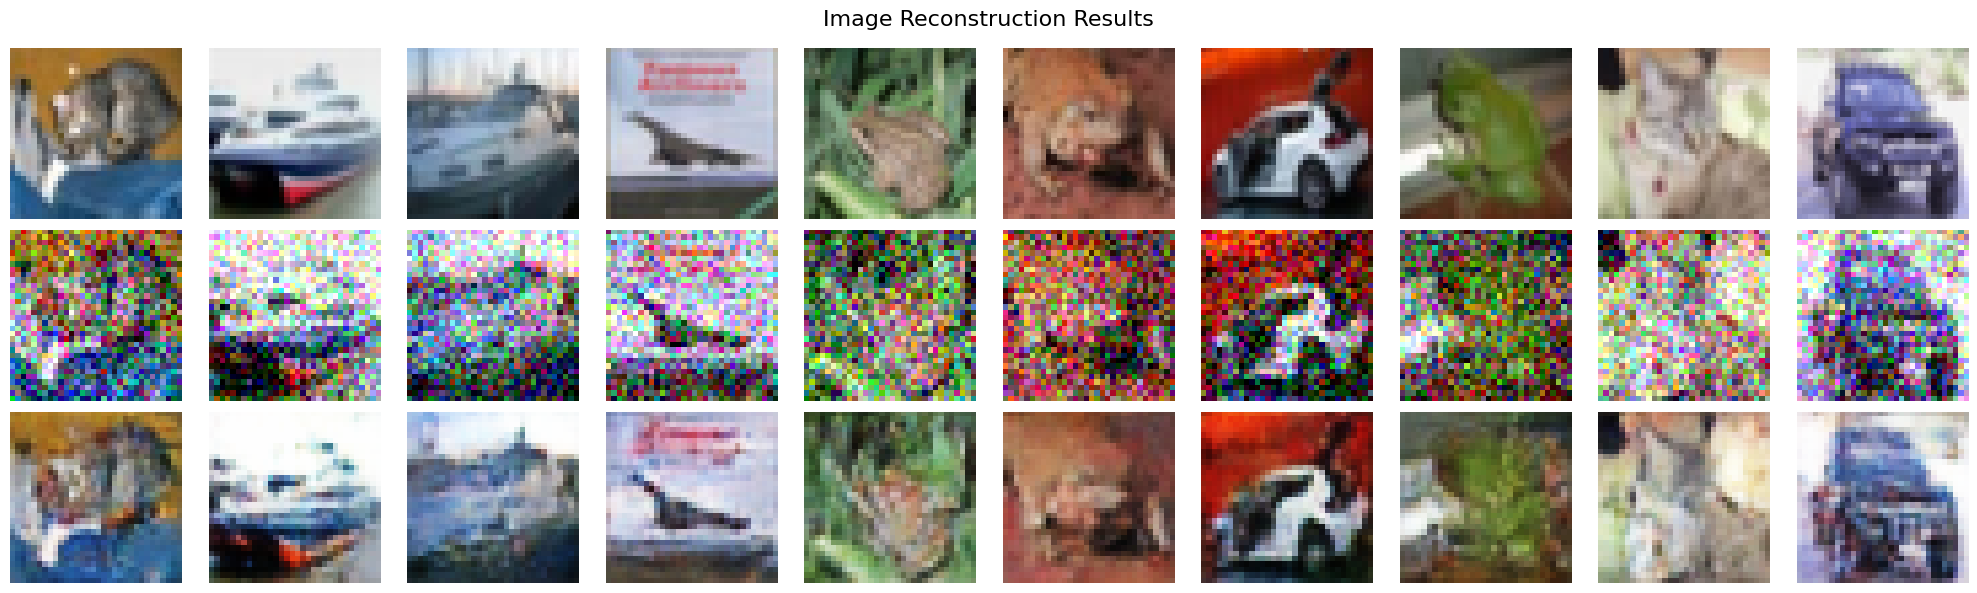

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# Take the first batch
original_batch = all_originals[0]
noisy_batch = all_noisy[0]
reconstructed_batch = all_reconstructed[0]

for i in range(10):
    axs[0, i].imshow(original_batch[i].numpy().transpose(1,2,0))
    axs[0, i].axis('off')
    axs[1, i].imshow(noisy_batch[i].numpy().transpose(1,2,0))
    axs[1, i].axis('off')
    axs[2, i].imshow(reconstructed_batch[i].numpy().transpose(1,2,0))
    axs[2, i].axis('off')

axs[0, 0].set_ylabel('Original', fontsize=14)
axs[1, 0].set_ylabel('Noisy', fontsize=14)
axs[2, 0].set_ylabel('Reconstructed', fontsize=14)

plt.suptitle('Image Reconstruction Results', fontsize=16)
plt.tight_layout()
plt.show()

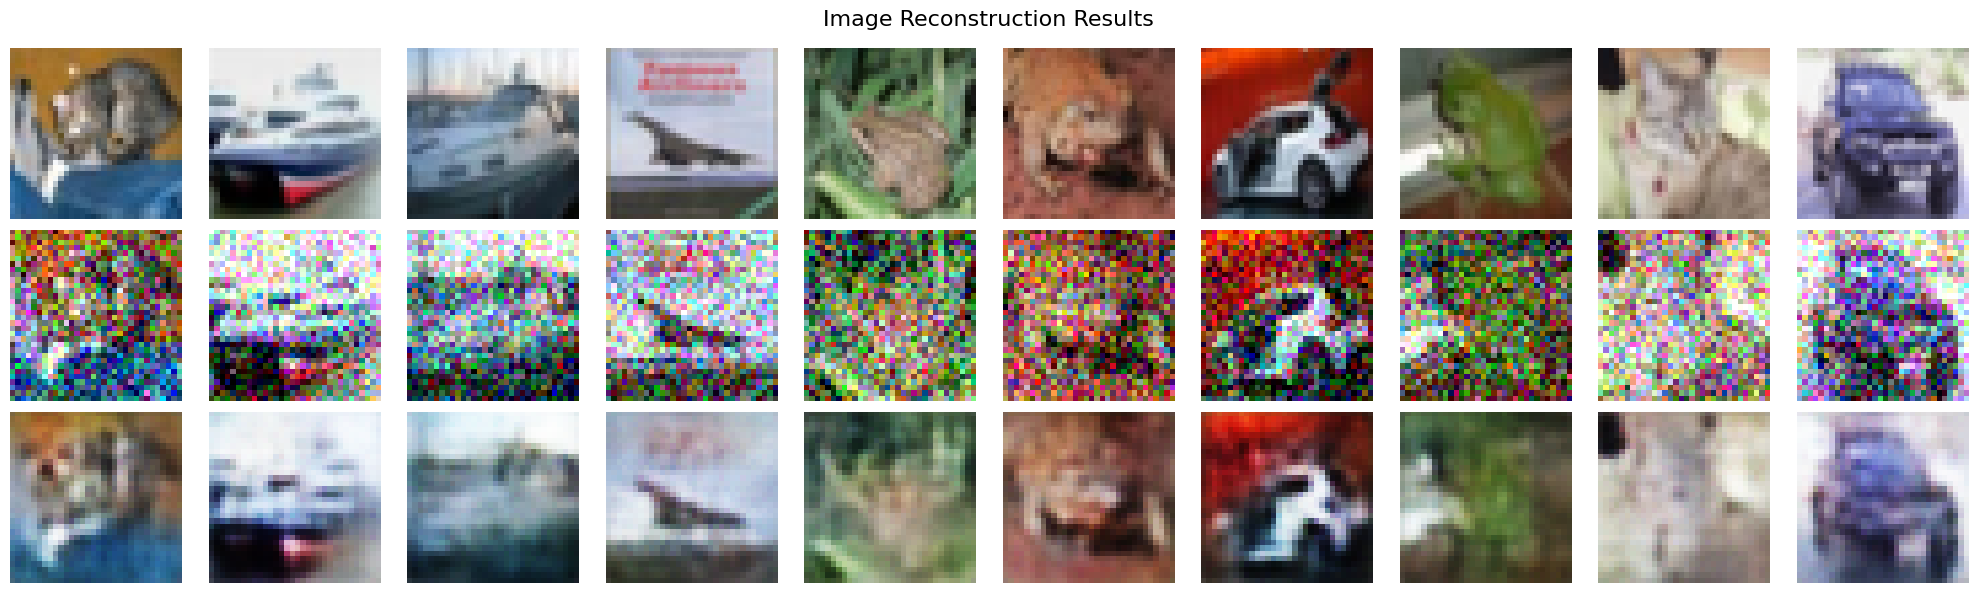

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

# Take the first batch
original_batch = all_originals[0]
noisy_batch = all_noisy[0]
reconstructed_batch = all_reconstructed[0]

for i in range(10):
    axs[0, i].imshow(original_batch[i].numpy().transpose(1,2,0))
    axs[0, i].axis('off')
    axs[1, i].imshow(noisy_batch[i].numpy().transpose(1,2,0))
    axs[1, i].axis('off')
    axs[2, i].imshow(reconstructed_batch[i].numpy().transpose(1,2,0))
    axs[2, i].axis('off')

axs[0, 0].set_ylabel('Original', fontsize=14)
axs[1, 0].set_ylabel('Noisy', fontsize=14)
axs[2, 0].set_ylabel('Reconstructed', fontsize=14)

plt.suptitle('Image Reconstruction Results', fontsize=16)
plt.tight_layout()
plt.show()

# PCA

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import cifar10

# Step 1: Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Combine train and test
X = np.concatenate((x_train, x_test), axis=0)  # (60000, 32, 32, 3)
y = np.concatenate((y_train, y_test), axis=0).flatten()  # (60000,)

# Step 2: Flatten images
X_flat = X.reshape(X.shape[0], -1)  # (60000, 3072)

# Step 3: Apply PCA
pca = PCA(n_components=432)
X_reduced = pca.fit_transform(X_flat)  # (60000, 972)

# Step 4: Reshape to (18,18,3)
X_reduced_reshaped = X_reduced.reshape(-1, 12, 12, 3)  # (60000, 18, 18, 3)

# Step 5: Create a custom PyTorch Dataset
class ReducedCIFAR10Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 3, 18, 18)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Step 6: Create dataset and dataloader
dataset = ReducedCIFAR10Dataset(X_reduced_reshaped, y)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# Example: iterate through the DataLoader
for batch_images, batch_labels in dataloader:
    print(batch_images.shape)  # (64, 3, 12, 12)
    print(batch_labels.shape)  # (64,)
    break

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
torch.Size([64, 3, 12, 12])
torch.Size([64])


In [ ]:
from torch.utils.data import DataLoader, Subset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = dataset
train_loader = dataloader

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def add_noise(imgs, noise_factor=0.2):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

G = Generator(in_channels=3).to(device)
D = Discriminator(in_channels=3).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# adversarial_loss = nn.BCELoss()
# reconstruction_loss = nn.L1Loss()
weighted_adversarial_loss = WeightedBCELoss()
weighted_reconstruction_loss = WeightedL1Loss()

epochs = 10
for epoch in range(epochs):
    G.train()
    D.train()
    for batch_idx, (data) in enumerate(train_loader):
        if len(data) == 3:
            imgs, labels, sw = data; sw = sw.to(device)
        else:
            imgs, labels = data; sw = None
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()

        reconstructed = G(noisy_imgs)
        g_adv = weighted_adversarial_loss(D(reconstructed), valid, sw)
        g_recon = weighted_reconstruction_loss(reconstructed, imgs, sw)
        g_loss = g_adv + 10 * g_recon  # Balance adversarial and reconstruction

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = weighted_adversarial_loss(D(imgs), valid, sw)
        fake_loss = weighted_adversarial_loss(D(reconstructed.detach()), fake, sw)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}")

G.eval()

total_recon_loss = 0
count = 0

all_originals = []
all_noisy = []
all_reconstructed = []

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        reconstructed_imgs = G(noisy_imgs)

        loss = F.l1_loss(reconstructed_imgs, imgs, reduction='sum')
        total_recon_loss += loss.item()
        count += imgs.size(0)

        # Optionally store a few batches for plotting
        if len(all_originals) < 5:
            all_originals.append(imgs.cpu())
            all_noisy.append(noisy_imgs.cpu())
            all_reconstructed.append(reconstructed_imgs.cpu())

# Final average reconstruction error (L1)
average_recon_error = total_recon_loss / (count)  # normalize by number of pixels
print(f"\nAverage Reconstruction L1 Error per pixel: {average_recon_error:.6f}")
# Average Reconstruction L1 Error per pixel: 0.174754 for full dataset
# Average Reconstruction L1 Error per pixel: 0.174630 for 10% of the data

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


Epoch [0/10] Batch 0/938                   Loss D: 0.7099, loss G: 698.5914
Epoch [0/10] Batch 10/938                   Loss D: 0.7026, loss G: 741.3414
Epoch [0/10] Batch 20/938                   Loss D: 0.6958, loss G: 662.9942
Epoch [0/10] Batch 30/938                   Loss D: 0.6929, loss G: 679.5997
Epoch [0/10] Batch 40/938                   Loss D: 0.6946, loss G: 706.4058
Epoch [0/10] Batch 50/938                   Loss D: 0.6945, loss G: 717.3901
Epoch [0/10] Batch 60/938                   Loss D: 0.6888, loss G: 695.5673
Epoch [0/10] Batch 70/938                   Loss D: 0.6877, loss G: 718.4542
Epoch [0/10] Batch 80/938                   Loss D: 0.6932, loss G: 699.6452
Epoch [0/10] Batch 90/938                   Loss D: 0.6881, loss G: 704.3981
Epoch [0/10] Batch 100/938                   Loss D: 0.6830, loss G: 727.5605
Epoch [0/10] Batch 110/938                   Loss D: 0.6858, loss G: 700.9870
Epoch [0/10] Batch 120/938                   Loss D: 0.6815, loss G: 718.63

# KMEANS coreset

In [ ]:
import numpy as np

class LightweightCoreset:
    def __init__(self, X, k, eps):
        self.X = X
        self.k = k
        self.eps = eps

    def set_k(self, k):
        self.k = k

    def set_X(self, X):
        self.X = X

    def _compute_m(self):
        #Computing coreset size
        self.m = np.int64(self.X.shape[1]*self.k*np.log2(self.k)/np.power(self.eps, 2))
        if self.m > self.X.shape[0]*0.2:
            self.m = int(self.k * 0.01 * self.X.shape[0])

    def _compute_coreset(self):
        #Algorithm 1 Lightweight coreset construction
        dist = np.power(self.X-self.X.mean(axis=0), 2).sum(axis=1)
        q = 0.5/self.X.shape[0] + 0.5*dist/dist.sum()
        indices = np.random.choice(self.X.shape[0], size=self.m, replace=True)
        X_cs = self.X[indices, :]
        w_cs = 1.0/(self.m*q[indices])
        return X_cs, w_cs, indices

    def compute(self):
        self._compute_m()
        print("coreset size: ", self.m)
        return self._compute_coreset()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Provided LightweightCoreset class
class LightweightCoreset:
    def __init__(self, X, k, eps):
        self.X = X
        self.k = k
        self.eps = eps

    def set_k(self, k):
        self.k = k

    def set_X(self, X):
        self.X = X

    def _compute_m(self):
        self.m = np.int64(self.X.shape[1] * self.k * np.log2(self.k) / np.power(self.eps, 2))
        if self.m > self.X.shape[0] * 0.2:
            self.m = int(self.k * 0.01 * self.X.shape[0])

    def _compute_coreset(self):
        dist = np.power(self.X - self.X.mean(axis=0), 2).sum(axis=1)
        q = 0.5 / self.X.shape[0] + 0.5 * dist / dist.sum()
        indices = np.random.choice(self.X.shape[0], size=self.m, replace=True, p=q)
        X_cs = self.X[indices, :]
        w_cs = 1.0 / (self.m * q[indices])
        return X_cs, w_cs, indices

    def compute(self):
        self._compute_m()
        print("Coreset size: ", self.m)
        return self._compute_coreset()

# 1. Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=len(trainset))  # Load entire dataset
data_iter = iter(trainloader)
images, labels = next(data_iter)  # All images and labels

# Flatten images
X = images.view(images.size(0), -1).numpy()

# 2. Create Lightweight coreset
k = 10  # for example, number of classes
eps = 0.1  # coreset error parameter

coreset = LightweightCoreset(X, k, eps)
X_cs, w_cs, indices = coreset.compute()

# 3. Create Dataset and DataLoader

class CoresetDataset(Dataset):
    def __init__(self, images, labels, weights):
        self.images = images
        self.labels = labels
        self.weights = weights

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.weights[idx]

# Select coreset images and labels
coreset_images = images[indices]
coreset_labels = labels[indices]
coreset_weights = torch.tensor(w_cs, dtype=torch.float32)

coreset_dataset = CoresetDataset(coreset_images, coreset_labels, coreset_weights)
coreset_loader = DataLoader(coreset_dataset, batch_size=64, shuffle=True)

# Example usage:
for img, label, weight in coreset_loader:
    print(img.shape, label.shape, weight.shape)
    break

Coreset size:  5000
torch.Size([64, 3, 32, 32]) torch.Size([64]) torch.Size([64])


In [ ]:
from torch.utils.data import DataLoader, Subset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = coreset_dataset
train_loader = coreset_loader

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def add_noise(imgs, noise_factor=0.2):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

G = Generator(in_channels=3).to(device)
D = Discriminator(in_channels=3).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# adversarial_loss = nn.BCELoss()
# reconstruction_loss = nn.L1Loss()
weighted_adversarial_loss = WeightedBCELoss()
weighted_reconstruction_loss = WeightedL1Loss()

epochs = 15
for epoch in range(epochs):
    G.train()
    D.train()
    for batch_idx, (data) in enumerate(train_loader):
        if len(data) == 3:
            imgs, labels, sw = data; sw = sw.to(device)
        else:
            imgs, labels = data; sw = None
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()

        reconstructed = G(noisy_imgs)
        g_adv = weighted_adversarial_loss(D(reconstructed), valid, sw)
        g_recon = weighted_reconstruction_loss(reconstructed, imgs, sw)
        g_loss = g_adv + 10 * g_recon  # Balance adversarial and reconstruction

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = weighted_adversarial_loss(D(imgs), valid, sw)
        fake_loss = weighted_adversarial_loss(D(reconstructed.detach()), fake, sw)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}")

G.eval()

total_recon_loss = 0
count = 0

all_originals = []
all_noisy = []
all_reconstructed = []

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs).to(device)

        reconstructed_imgs = G(noisy_imgs)

        loss = F.l1_loss(reconstructed_imgs, imgs, reduction='sum')
        total_recon_loss += loss.item()
        count += imgs.size(0)

        # Optionally store a few batches for plotting
        if len(all_originals) < 5:
            all_originals.append(imgs.cpu())
            all_noisy.append(noisy_imgs.cpu())
            all_reconstructed.append(reconstructed_imgs.cpu())

# Final average reconstruction error (L1)
average_recon_error = total_recon_loss / (count)  # normalize by number of pixels
print(f"\nAverage Reconstruction L1 Error per pixel: {average_recon_error:.6f}")
# Average Reconstruction L1 Error per pixel: 0.174754 for full dataset
# Average Reconstruction L1 Error per pixel: 0.174630 for 10% of the data

Epoch [0/15] Batch 0/79                   Loss D: 7.0855, loss G: 28.1371
Epoch [0/15] Batch 10/79                   Loss D: 6.8047, loss G: 19.7091
Epoch [0/15] Batch 20/79                   Loss D: 6.9336, loss G: 16.7918
Epoch [0/15] Batch 30/79                   Loss D: 6.4575, loss G: 15.0225
Epoch [0/15] Batch 40/79                   Loss D: 6.6719, loss G: 15.2140
Epoch [0/15] Batch 50/79                   Loss D: 7.0092, loss G: 15.3704
Epoch [0/15] Batch 60/79                   Loss D: 6.6044, loss G: 14.0175
Epoch [0/15] Batch 70/79                   Loss D: 7.0174, loss G: 15.0684
Epoch [1/15] Batch 0/79                   Loss D: 7.1324, loss G: 14.8429
Epoch [1/15] Batch 10/79                   Loss D: 7.0646, loss G: 14.7786
Epoch [1/15] Batch 20/79                   Loss D: 7.3658, loss G: 15.2045
Epoch [1/15] Batch 30/79                   Loss D: 6.4769, loss G: 13.1481
Epoch [1/15] Batch 40/79                   Loss D: 6.6835, loss G: 13.4280
Epoch [1/15] Batch 50/79   